In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import shap
import os
from functools import partial
import joblib
from sklearn.preprocessing import OneHotEncoder
optuna.logging.set_verbosity(optuna.logging.WARNING)
import optuna

import src.non_time_series_model as ntsm
##

## Map breeding stage back into dataframe


In [ ]:
mapping_path = 'C:\Users\eduar\Documents\Tuebingen\Data Literacy\projectP\data\datasets_penguins'

In [12]:
mapping_frame = ntsm.load_mapping(mapping_path)

In [ ]:
df = pd.read_csv('/Users/philipp/Documents/02_Master_Uni/Uni_Tübingen/Semester_1/06 Data Literacy/02 Project/penguins_final_with_era5.csv')
df_base = df.copy()

df_base = df_base.drop(columns=['Unnamed: 0'])


In [212]:
df_adelie = df_base[df_base['common_name'] == 'Adelie Penguin']

### Graphs

Track_ID and minutes since last measure mean are not important, since they are assumed to not have a relationship (penguins are assumed IID)


In [157]:
mapping_path = '/Users/philipp/Documents/02_Master_Uni/Uni_Tübingen/Semester_1/06 Data Literacy/02 Project/datasets_penguins'
filepath = '/Users/philipp/Documents/02_Master_Uni/Uni_Tübingen/Semester_1/06 Data Literacy/02 Project/penguins_final_with_era5.csv'


## Model with 5 Fold CV


=== Nested CV for Random Forest ===
RF Fold 1: Best params: {'n_estimators': 253, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 0.600565857530626}, R²: 0.876, RMSE: 95.998
RF Fold 2: Best params: {'n_estimators': 399, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.9020568696119333}, R²: 0.874, RMSE: 90.542
RF Fold 3: Best params: {'n_estimators': 349, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.8672971069678778}, R²: 0.843, RMSE: 107.422
RF Fold 4: Best params: {'n_estimators': 497, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 0.7823285215847289}, R²: 0.892, RMSE: 88.363
RF Fold 5: Best params: {'n_estimators': 318, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 0.5632162401046197}, R²: 0.890, RMSE: 90.289


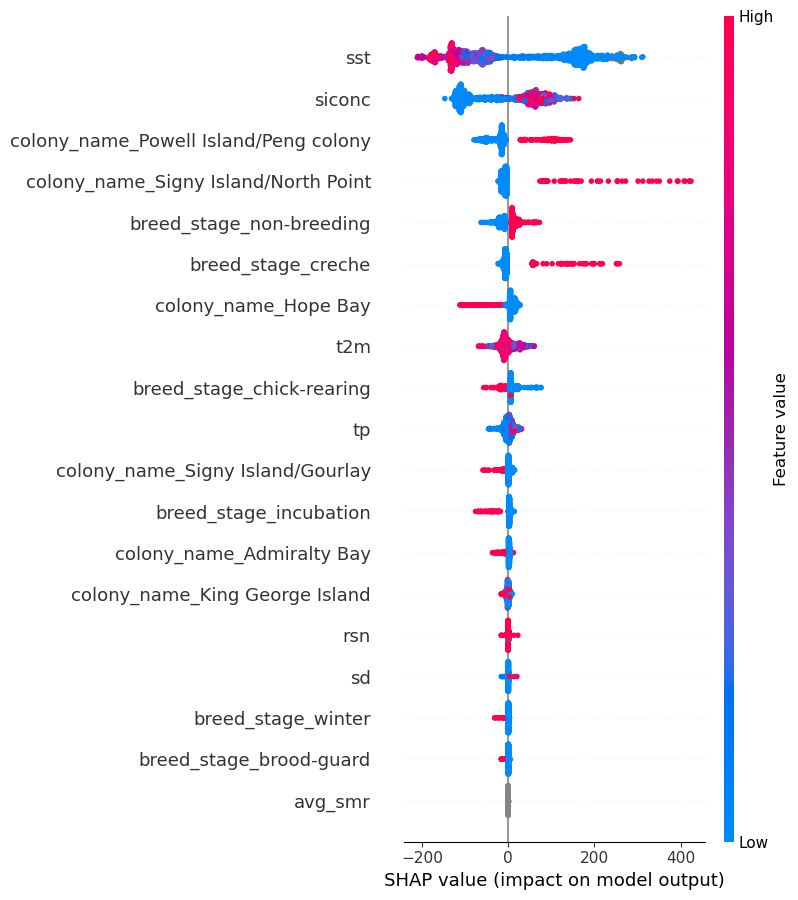


Nested CV Random Forest - Average R²: 0.875 - Average RMSE: 94.523

=== Nested CV for XGBoost ===
XGB Fold 1: Best params: {'n_estimators': 182, 'learning_rate': 0.08391259941879944, 'max_depth': 9, 'subsample': 0.9335047020157347, 'colsample_bytree': 0.8382872715670753, 'min_child_weight': 2, 'gamma': 3.21836710602313, 'reg_alpha': 3.832209271559718, 'reg_lambda': 1.7830685377344428}, R²: 0.853, RMSE: 104.305
XGB Fold 2: Best params: {'n_estimators': 351, 'learning_rate': 0.03642883746790867, 'max_depth': 8, 'subsample': 0.9925811695001574, 'colsample_bytree': 0.8695200408484042, 'min_child_weight': 10, 'gamma': 1.5416048229067898, 'reg_alpha': 0.8981652202816228, 'reg_lambda': 0.5064444665505929}, R²: 0.876, RMSE: 89.918
XGB Fold 3: Best params: {'n_estimators': 384, 'learning_rate': 0.0167642090345965, 'max_depth': 9, 'subsample': 0.8670166652575346, 'colsample_bytree': 0.829836916077608, 'min_child_weight': 2, 'gamma': 1.432651462516768, 'reg_alpha': 4.800927444389492, 'reg_lambda

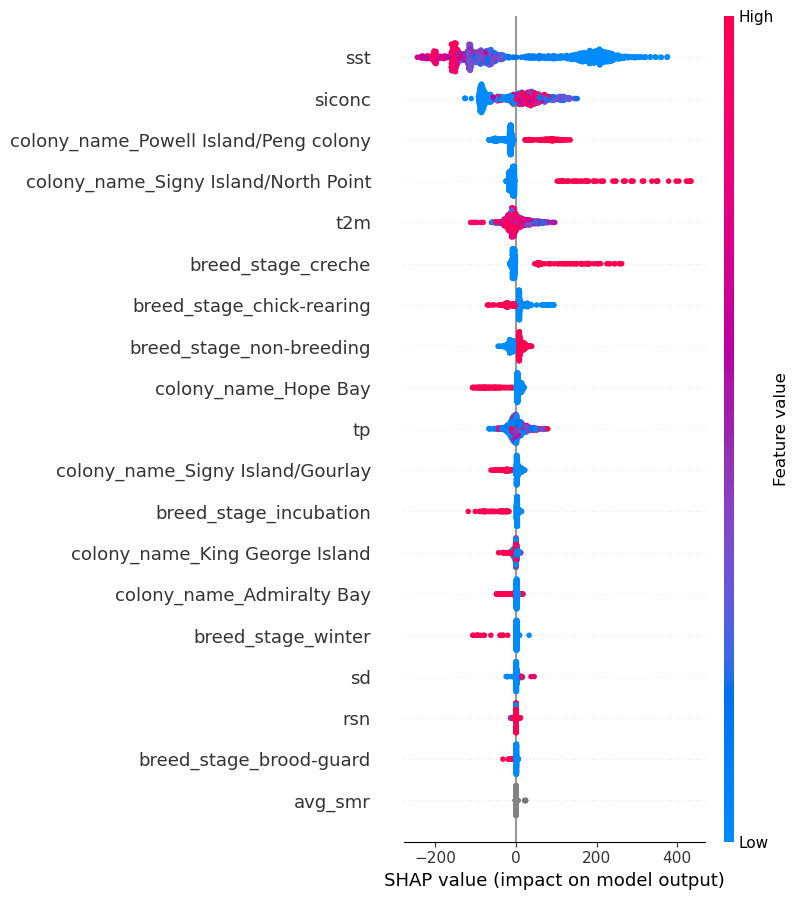


Nested CV XGBoost - Average R²: 0.872 - Average RMSE: 95.760


In [25]:
def main():
    filepath = '../data/penguins_final_with_era5.csv'
    mapping_path = '../data/datasets_penguins'
    
    # Load and preprocess data (adjust smooth_climate as needed)
    df_adelie = ntsm.load_and_preprocess_data(mapping_path, filepath, smooth_climate=False, window=7)
    X, y = ntsm.get_features_and_target(df_adelie)
    
    # One-hot encode categorical features
    numeric_features = ['tp', 't2m', 'sst', 'siconc', 'sd', 'rsn', 'avg_smr']
    categorical_features = ['colony_name', 'breed_stage']
    
    X_numeric = X[numeric_features]
    X_categorical = X[categorical_features].astype(str)
    
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoder.fit(X_categorical)
    X_cat_encoded = encoder.transform(X_categorical)
    encoded_feature_names = encoder.get_feature_names_out(categorical_features)
    X_cat_df = pd.DataFrame(X_cat_encoded, columns=encoded_feature_names, index=X.index)
    
    # Combine numeric and encoded categorical features
    X_final = pd.concat([X_numeric, X_cat_df], axis=1)
    
    # Run nested cross-validation on the entire dataset
    print("\n=== Nested CV for Random Forest ===")
    ntsm.nested_cv_rf(X_final, y, outer_splits=5, inner_trials=20)
    
    print("\n=== Nested CV for XGBoost ===")
    ntsm.nested_cv_xgb(X_final, y, outer_splits=5, inner_trials=20)

if __name__ == '__main__':
    main()


In [22]:
# load data back from pickle file
all_rf_predictions = joblib.load('rf_nested_predictions.pkl')
all_xgb_predictions = joblib.load('xgb_nested_predictions.pkl')


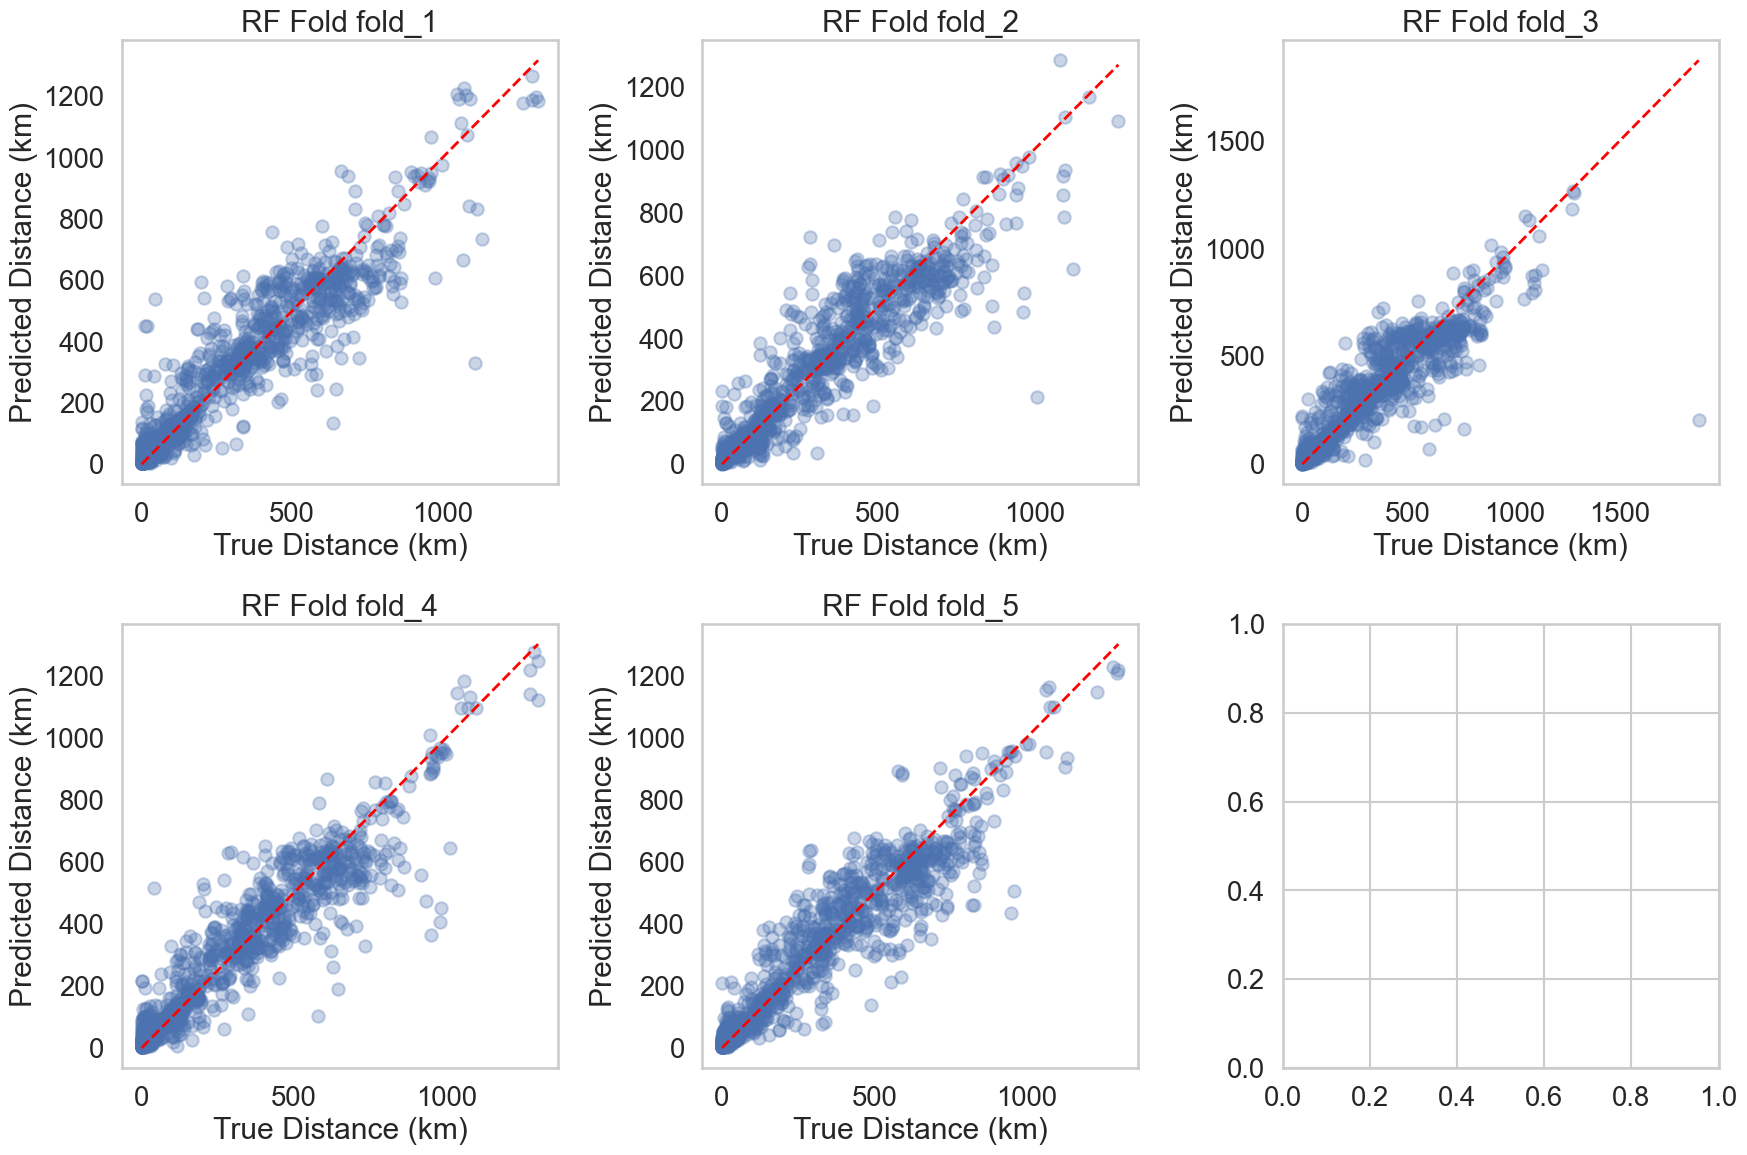

In [286]:
ntsm.plot_predictions(all_rf_predictions)

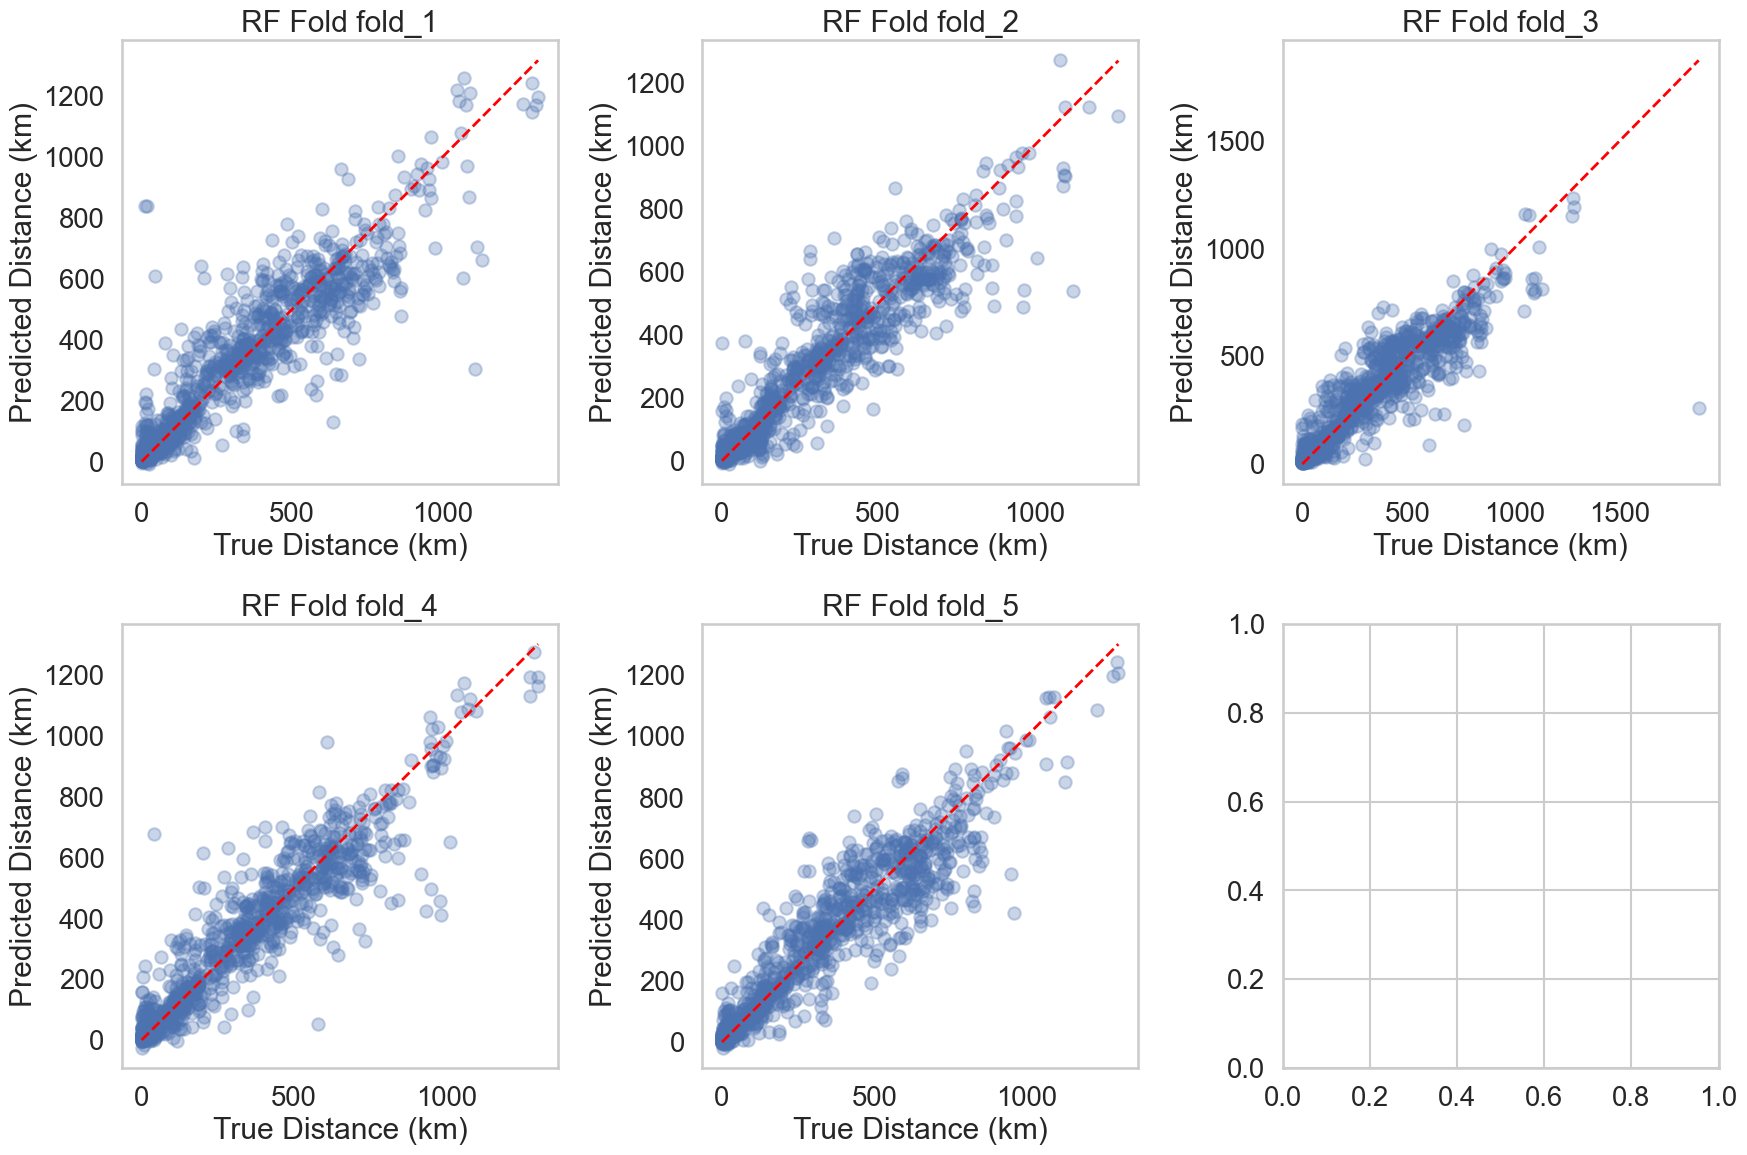

In [285]:
ntsm.plot_predictions(all_xgb_predictions)

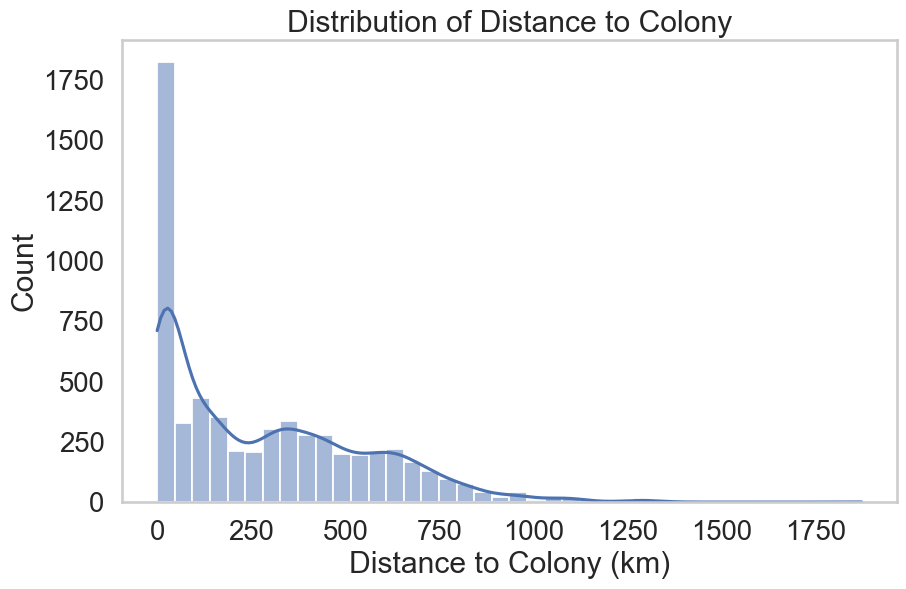

In [284]:
# plot mean distance to colony
ntsm.plot_distance_to_colony(df_adelie)

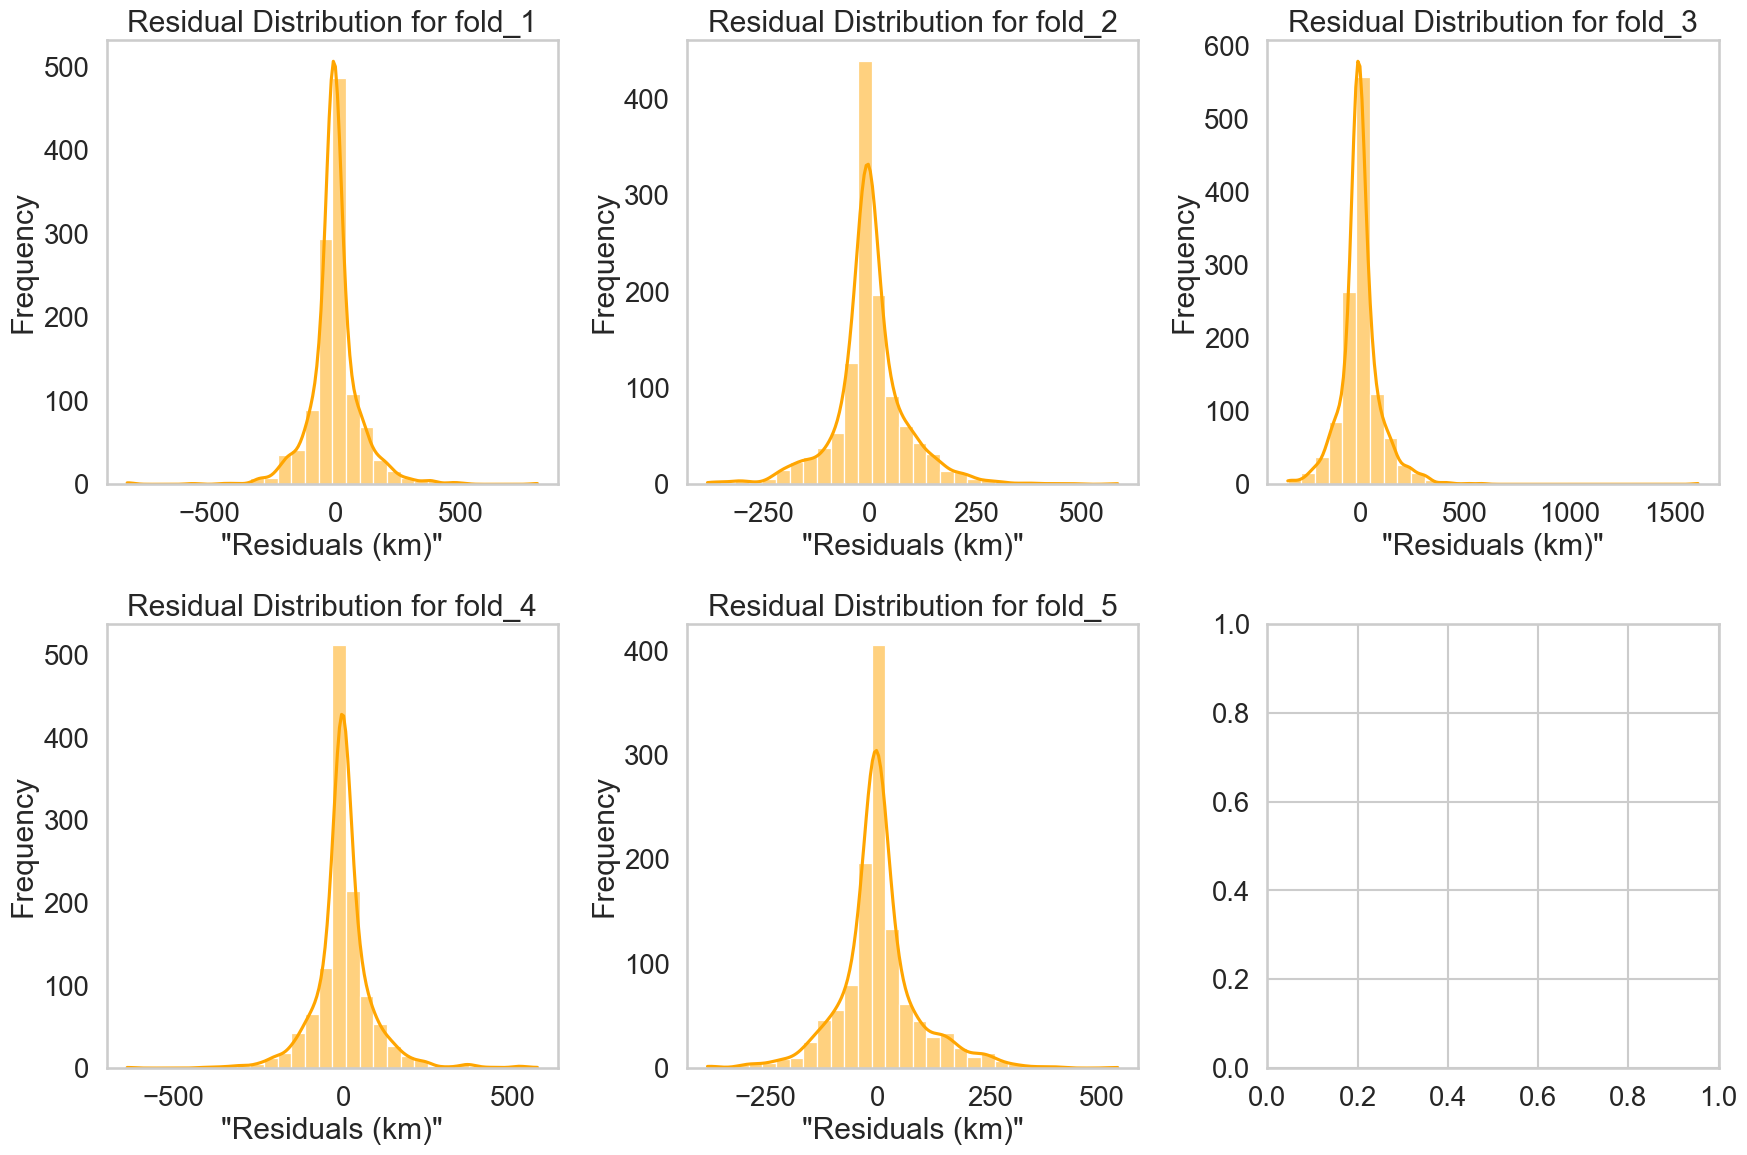

In [297]:
# for each fold, plot the residuals of XGB
ntsm.plot_residuals(all_xgb_predictions)

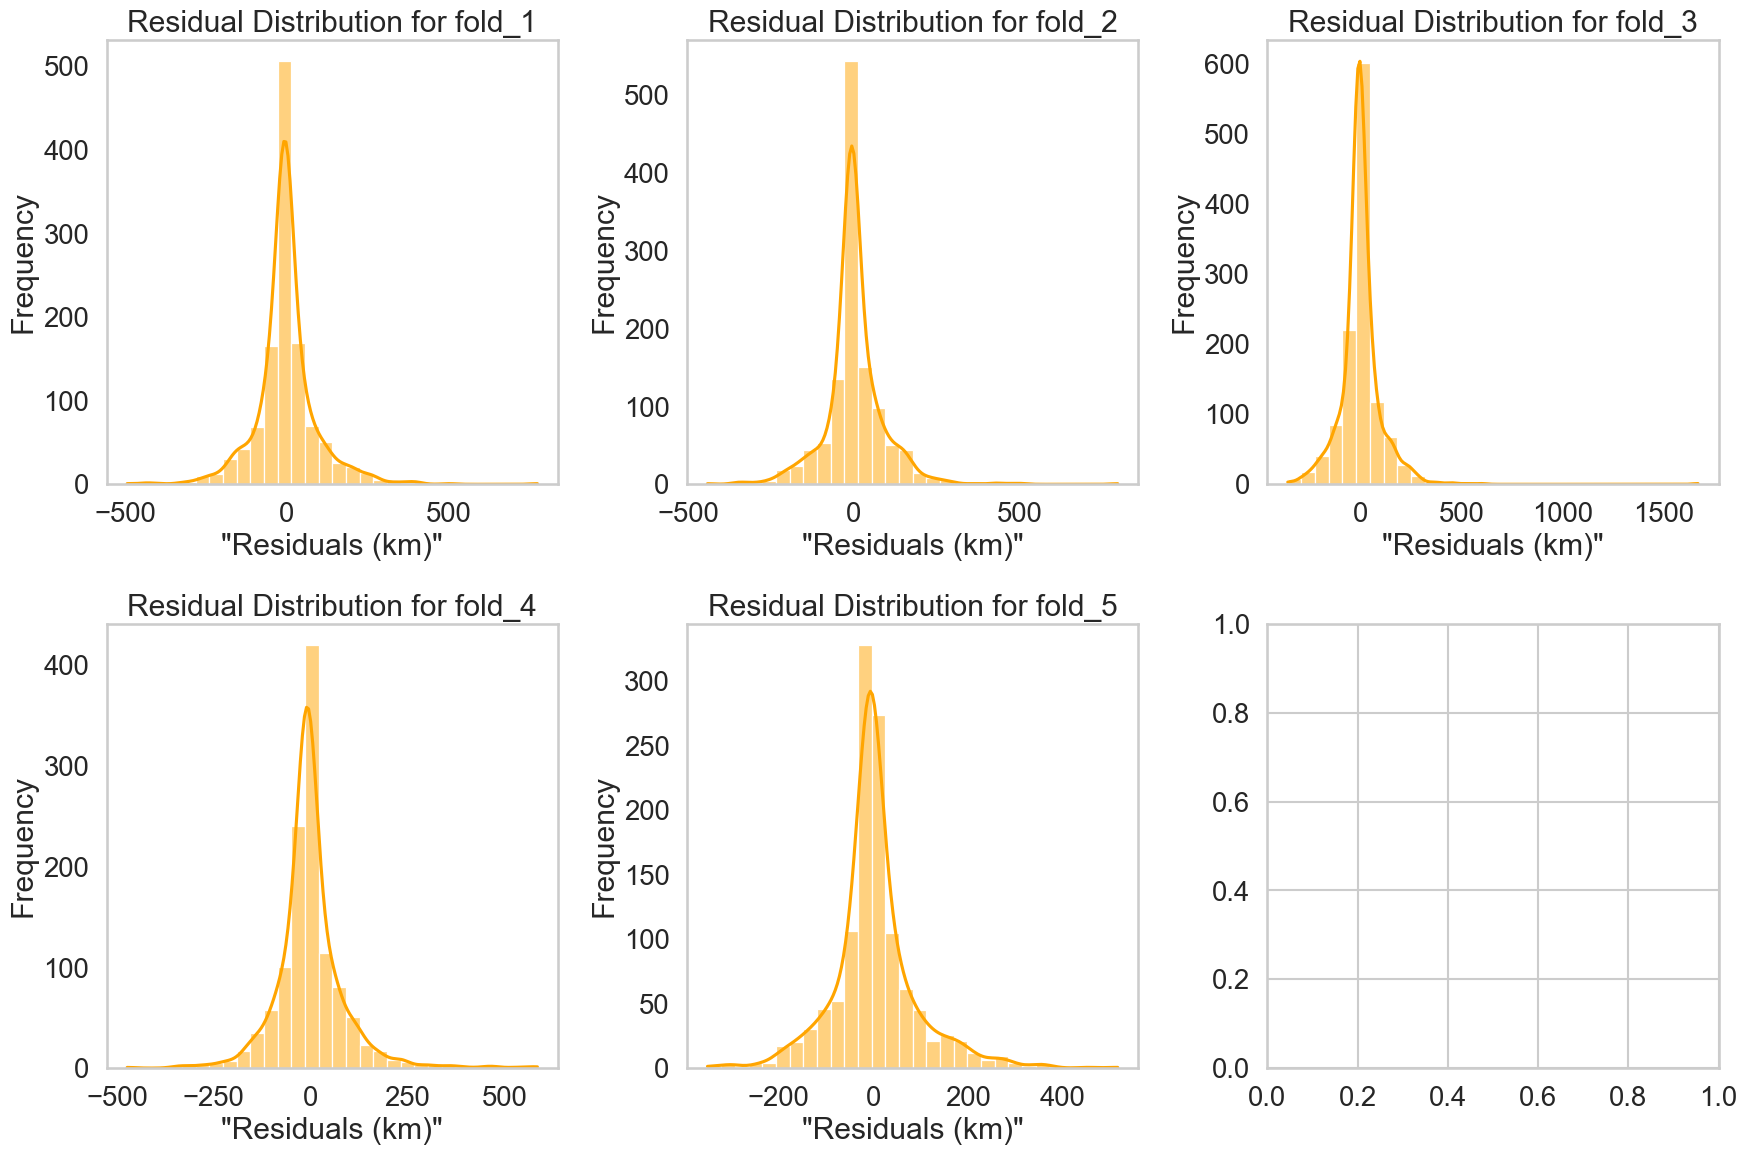

In [298]:
# for each fold, plot the residuals of RF
ntsm.plot_residuals(all_rf_predictions)

### example for one fold and some 20% of the true data (randomly sampeled)

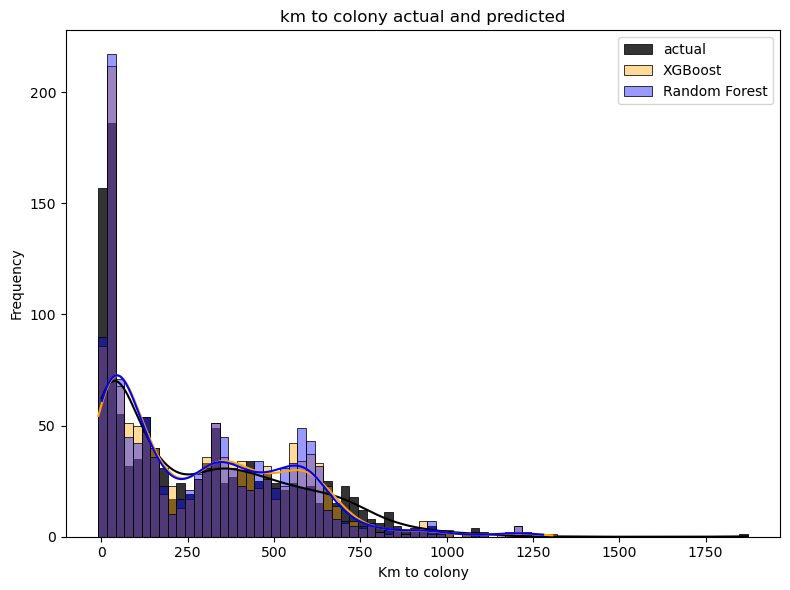

In [23]:
ntsm.plot_random_sample(df = df_adelie, fold = 'fold_1', predictions_rf= all_rf_predictions, predictions_xgb = all_xgb_predictions)